# Orientaiton optimization for a planar transient heat problem
[![Google Collab Book](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/meyer-nils/torch-fem/blob/main/examples/basic/planar/thermal_transient.ipynb)

Achieve faster global conductivity by optimizing local material orientation.

In [1]:
import torch
from tqdm import tqdm

import matplotlib.pyplot as plt
from torchfem.examples import get_example_file
from torchfem.io import import_mesh
from torchfem.materials import OrthotropicConductivity2D
from torchfem.planar import PlanarHeat

from matplotlib import animation
from torchfem.plot_utils import embed_animation_gif

from torchfem.rotations import planar_rotation

# Set default data type to double precision
torch.set_default_dtype(torch.float64)

# Dimensions (thickness of plate t and edge length L)
t = 0.01
L = 0.2

## Transient heat equation on planar domain

In [2]:
# material properties
kappa_l = 500.0
kappa_t = 50.0
rho = 7850.0
cp = 500.0

In [3]:
# Material model
material = OrthotropicConductivity2D(kappa_1=kappa_l, kappa_2=kappa_t, rho=rho, cp=cp)

# Import mesh
mesh = import_mesh(get_example_file("plate_hole.vtk"), material)

# origin in center
mesh.nodes[:, :2] -= 0.5 * L

# get radius
distance_to_center = torch.linalg.norm(mesh.nodes, dim=-1)
R = distance_to_center.min()

plate = PlanarHeat(mesh.nodes, mesh.elements, material)
plate.thickness[:] = t

# Fixed temperature at left end
left = plate.nodes[:, 0] < -0.5 * L + 1e-6
# plate.constraints[left] = True
# plate.displacements[left, 0] = 5.0
# plate.forces[left, 0] = -5.0

# Fixed temperature at right end
right = plate.nodes[:, 0] > 0.5 * L - 1e-6
plate.constraints[right] = True
plate.displacements[right, 0] = 20.0




# solver settings
end_time = 120.0
delta_t = 1.0

times = torch.tensor([0.0, end_time])

# Solve
temp_init, rfl_init, hf_init, temp_grad_init, _ = plate.time_integration(
    times, delta_t, verbose=False, return_intermediate=True
)

### Solve initial configuraton

the main material axis is the global x-axis. 

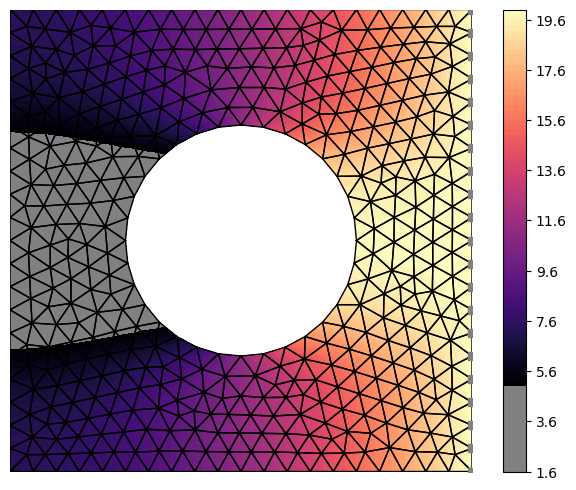

In [4]:
# Define vmin and vmax
import matplotlib.colors as mcolors

vmin, vmax = 5.0, 20.0

# Create a colormap based on viridis, but set under-range color to red
cmap = plt.cm.magma.copy()
cmap.set_under("gray")  # values below vmin will be red

# Create a normalization that respects vmin/vmax
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

plate.plot(
    node_property=temp_init[90, :, 0],
    vmin=5,
    vmax=20,
    cmap=cmap,
    norm=norm,
    colorbar=True,
    levels=100,
)

The heat flux might not be optimal. Due to smaller transverse conducitiy, heat transfer in $y$-direction is smaller. Hence, this region is not fully heated up to 5° after 100 seconds.  

\
Temperatures below $T_\text{min}$ at the left edge are penalized and summed up for each timestep.

$f = \int_{0}^{t_{\text{end}}} \int_{-H/2}^{H/2} \left(\mathrm{clamp}\left( \left. T \right|_{x=-L/2}, -\infty, T_\text{min}  \right) - T_\text{min} \right)^2 \, \mathrm{d}y \mathrm{d}t$

We implement the discretized version below, exploiting equdistant temporal and spatial increments.

In [5]:
target_temp = 5.0
def delta_temp_left(phi):
    rotation = planar_rotation(phi)

    plate.material = material.vectorize(plate.n_elem).rotate(rotation)
    temp, *_  = plate.time_integration(times, delta_t, return_intermediate=True)
    
    torch.clamp(temp[:, left, :], -1e64, target_temp) - target_temp
    
    loss = (torch.clamp(temp[:, left, :], -1e64, target_temp) - target_temp)**2.0

    return loss.sum(), temp[:, left].squeeze(-1)

### Unconstrained Optimization

Orientations in each element are initialized with $0°$.


> Actually, $\mathfrak{so}(1)$ is not the perfect metric space for our design variable, since $\boldsymbol{R} \star \boldsymbol{\kappa} = \left(-\boldsymbol{R}\right) \star \boldsymbol{\kappa}$. 

In [6]:
phi = torch.zeros(len(plate.elements))
phi.requires_grad = True

optimizer = torch.optim.Adam([phi], lr=0.1)


loss_it, phi_it, temp_left_it = [], [], []
for _ in tqdm(range(50)):
    optimizer.zero_grad()
    objective, temp_left = delta_temp_left(phi)
    loss_it.append(objective.detach().item())
    temp_left_it.append(temp_left.detach().clone())
    
    objective.backward()
    optimizer.step()
    
    phi_it.append(phi.detach().clone())

100%|██████████| 50/50 [00:39<00:00,  1.27it/s]



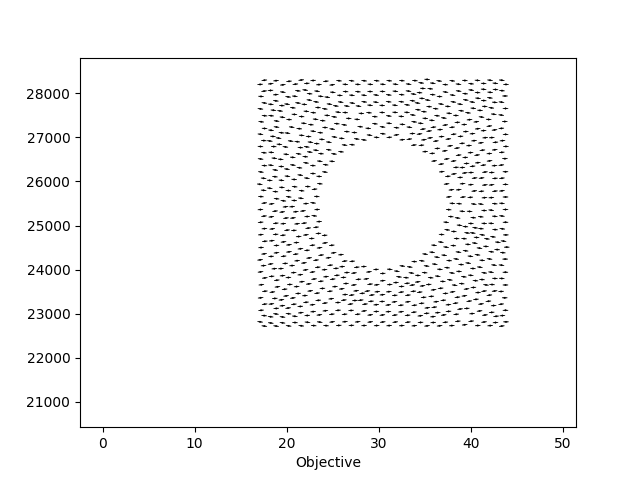

In [7]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig, ax1 = plt.subplots()
(line_loss,) = ax1.plot(
    range(len(loss_it)), torch.zeros(len(loss_it)), "k-", marker="o"
)

ax1.set_ylim(0.95*min(loss_it), 1.05*max(loss_it))
ax1.set_xlabel("Iterations")
ax1.set_xlabel("Objective")

# this is an inset axes over the main axes
ax2 = inset_axes(
    ax1,
    width="75%",
    height="75%",
    loc=1,
)

with torch.no_grad():
    phi0 = phi_it[0]
    ori_vec = torch.stack((torch.cos(phi0), torch.sin(phi0)), dim=-1)
    plate.plot(linewidth=0.0, ax=ax2, bcs=False)
    centers = plate.nodes[plate.elements].mean(dim=-2)
    quiver_plus = ax2.quiver(
        centers[:, 0],
        centers[:, 1],
        ori_vec[:, 0],
        ori_vec[:, 1],
        pivot="middle",
    )
    quiver_minus = ax2.quiver(
        centers[:, 0],
        centers[:, 1],
        -ori_vec[:, 0],
        -ori_vec[:, 1],
        pivot="middle",
    )
    ax2.set_aspect("equal")


@torch.no_grad()
def animate(it):
    phi_plot = phi_it[it]
    # ori_vec = torch.stack((torch.cos(phi_plot), torch.sin(phi_plot)), dim=-1)
    
    quiver_plus.set_UVC(torch.cos(phi_plot), torch.sin(phi_plot))
    quiver_minus.set_UVC(-torch.cos(phi_plot), -torch.sin(phi_plot))

    line_loss.set_data(range(len(loss_it[:it])), loss_it[:it])
    


    return (line_loss, quiver_plus, quiver_minus)



anim = animation.FuncAnimation(
    fig,
    animate,
    frames=range(len(loss_it)),
    interval=20,
    blit=True,
    repeat=False,
)

plt.close(fig)  # prevent static plot
embed_animation_gif(anim, fps=10)  # <- This embeds the GIF directly


### Compute the solution with optimized orientations.

In [8]:
temp_opti, *_ = plate.time_integration(times, delta_t, return_intermediate=True)

plate.material = material.vectorize(len(plate.elements)).rotate(
    planar_rotation(0.5 * torch.pi)
)
temp_90, *_ = plate.time_integration(times, delta_t, return_intermediate=True)


### Animate the temperature evolution for the naive guess (globally 0°), the naive worst case (globally 90°) and for the optimized design. 


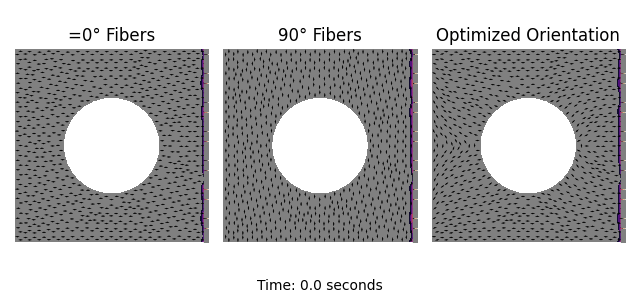

In [9]:
fig, (ax_init, ax_90, ax_opti) = plt.subplots(1, 3)
time_text = fig.text(0.5, 0.0, "Time: 0.0 seconds", ha="center", va="bottom")
fig.set_figheight(fig.get_figheight()*0.61)
fig.set_tight_layout("tight")


def plot_state(i):
    plate.plot(
        node_property=temp_init[i].ravel(),
        cmap=cmap,
        norm=norm,
        title="=0° Fibers",
        ax=ax_init,
        vmin=5.0,
        vmax=20.0,
        linewidth=0.0,
    )
    plate.plot(
        node_property=temp_90[i].ravel(),
        cmap=cmap,
        norm=norm,
        title="90° Fibers",
        ax=ax_90,
        vmin=5.0,
        vmax=20.0,
        linewidth=0.0,
    )
    plate.plot(
        node_property=temp_opti[i].ravel(),
        cmap=cmap,
        norm=norm,
        title="Optimized Orientation",
        ax=ax_opti,
        vmin=5.0,
        vmax=20.0,
        linewidth=0.0,
    )

    centers = plate.nodes[plate.elements].mean(dim=-2)
    ax_init.quiver(
        centers[:, 0],
        centers[:, 1],
        torch.ones(len(centers)),
        torch.zeros(len(centers)),
        pivot="middle",
    )
    ax_init.quiver(
        centers[:, 0],
        centers[:, 1],
        -torch.ones(len(centers)),
        -torch.zeros(len(centers)),
        pivot="middle",
    )
    ax_90.quiver(
        centers[:, 0],
        centers[:, 1],
        torch.zeros(len(centers)),
        torch.ones(len(centers)),
        pivot="middle",
    )
    ax_90.quiver(
        centers[:, 0],
        centers[:, 1],
        -torch.zeros(len(centers)),
        -torch.ones(len(centers)),
        pivot="middle",
    )
    ax_opti.quiver(
        centers[:, 0],
        centers[:, 1],
        torch.cos(phi_it[-1]),
        torch.sin(phi_it[-1]),
        pivot="middle",
    )
    ax_opti.quiver(
        centers[:, 0],
        centers[:, 1],
        -torch.cos(phi_it[-1]),
        -torch.sin(phi_it[-1]),
        pivot="middle",
    )
    


def animate(i):
    # Note. this is pretty slow and should be optimized.
    # updating the data on the tricontour is not intended in mpl.
    ax_init.clear()
    ax_opti.clear()
    ax_90.clear()

    plot_state(i)

    time_text.set_text(f"Time: {i * delta_t:.1f} seconds")
    
    if i == 0:
        fig.set_tight_layout("tight")

    return (time_text,)


anim = animation.FuncAnimation(
    fig,
    animate,
    init_func=plot_state(0),
    frames=range(len(temp_opti)),
    interval=20,
    blit=False,
    repeat=False,
)

plt.close(fig)  # prevent static plot
embed_animation_gif(anim, fps=20)  # <- This embeds the GIF directly
